# Python для анализа данных

## Что такое SQL. Как писать запросы. Работа с Clickhouse. 

Автор: *Ян Пиле, НИУ ВШЭ*

Язык SQL очень прочно влился в жизнь аналитиков и требования к кандидатам благодаря простоте, удобству и распространенности. Часто SQL используется для формирования выгрузок, витрин (с последующим построением отчетов на основе этих витрин) и администрирования баз данных. Поскольку повседневная работа аналитика неизбежно связана с выгрузками данных и витринами, навык написания SQL запросов может стать крайне полезным умением. 

Мы будем работать с колоночной базой данных Clickhouse. Прочитать, детали о том, что такое Clickhouse и какой диалект SQL там используется, можно прочитать в документации:

https://clickhouse.tech/docs/ru/

Рассказ о том, что такое базы данных и в каком виде данные хранятся, требуется отдельный – тема очень большая. Мы будем представлять себе базу данных как набор хранящихся на нескольких серверах таблиц с именованными колонками (как в Excel-файлах, только больше (на самом деле это не совсем так, но нам усложнение логики не потребуется)

#### Структура sql-запросов

Общая структура запроса выглядит следующим образом:

* SELECT ('столбцы или * для выбора всех столбцов; обязательно')
* FROM ('таблица; обязательно')
* WHERE ('условие/фильтрация, например, city = 'Moscow'; необязательно')
* GROUP BY ('столбец, по которому хотим сгруппировать данные; необязательно')
* HAVING ('условие/фильтрация на уровне сгруппированных данных; необязательно')
* ORDER BY ('столбец, по которому хотим отсортировать вывод; необязательно')
* LIMIT ('число, сколько строк результата надо вывести; необязательно')

Для начала попробуем порешать задачи в интерфейсе Clickhouse. Он называется Tabix.

Web-нтерфейс Clickhouse располагается по адресу: **Tabix.beslan.pro** (прямо на занятии зайдем и посмотрим)

Наша база данных Clickhouse состоит из четырех таблиц:
    
* **events** (события в приложении)
* **checks** (чеки покупок в приложении)
* **devices** (идентификаторы устройств, на которые приложения установлены)
* **installs** (установки приложений)

Возьмем одну из таблиц и опробуем элементы запроса на ней. Пусть это будет таблица events.
Для простоты визуализации результатов запроса мы будем загружать данные прямо в Python (для этого я уже написал функцию, а уже потом будем разбирать, как эта функция работает.

In [1]:
import json # Чтобы разбирать поля
import requests # чтобы отправлять запрос к базе
import pandas as pd # чтобы в табличном виде хранить результаты запроса

# имена явки пароли. если хотите, чтобы считалось с вашего логина, вставьте сюда свои логин и пароль
USER = 'student'
PASS = 'dpo_python_2020'
HOST = 'http://hse.beslan.pro:8080/'

def get_clickhouse_data(query,
                        host=HOST, 
                        USER = USER, 
                        PASS = PASS, 
                        connection_timeout = 1500, 
                        dictify=True, 
                        **kwargs):
    NUMBER_OF_TRIES = 5  # Количество попыток запуска
    DELAY = 10           #время ожидания между запусками
    import time
    params = kwargs      #если вдруг нам нужно в функцию положить какие-то параметры
    if dictify:
        query += "\n FORMAT JSONEachRow"   # dictify = True отдает каждую строку в виде JSON'a

    for i in range(NUMBER_OF_TRIES):

        headers = {'Accept-Encoding': 'gzip'}

        r = requests.post(host, 
                          params = params, 
                          auth=(USER, PASS), 
                          timeout = connection_timeout, 
                          data=query
                          )              # отправили запрос на сервер

        if r.status_code == 200 and not dictify:    
            return r.iter_lines()         # генератор :)
        elif r.status_code == 200 and dictify:
            return (json.loads(x) for x in r.iter_lines()) # генератор :)
        
        else:
            print('ATTENTION: try #%d failed' % i)
            if i != (NUMBER_OF_TRIES - 1):
                print(r.text)
                time.sleep(DELAY * (i + 1))
            else:
                raise(ValueError, r.text)
                
def get_data(query):
    return pd.DataFrame(list(get_clickhouse_data(query, dictify=True)))

SQL-запросы мы будем сгружать в функцию в виде текста. 

In [2]:
query = """
select  *
from events
limit 10
"""

In [3]:
get_data(query)

,AppPlatform,events,EventDate,DeviceID
0,android,8,2019-09-29,7429291373250434008
1,android,175,2019-09-15,7429291824672902510
2,android,0,2019-09-17,7429291824672902510
3,android,0,2019-09-26,7429291824672902510
4,android,4,2019-04-29,7429292273953361459
5,android,38,2019-08-20,7429293114537639018
6,android,38,2019-05-21,7429298825563999474
7,android,4,2019-05-26,7429298825563999474
8,android,100,2019-08-07,7429300397574411770
9,android,26,2019-01-31,7429301272237917347


Отлично! Мы достали 10 записей таблицы events. Теперь опробуем выражение where: достанем только те записи, которые соответствуют платформе iOS.

In [14]:
query = """
select  *
from events
where AppPlatform ='iOS'
limit 10
"""

In [15]:
get_data(query)

,AppPlatform,events,EventDate,DeviceID
0,iOS,8,2019-05-31,9876384474599951858
1,iOS,0,2019-06-02,9876384474599951858
2,iOS,36,2019-03-22,9876391923147626977
3,iOS,6,2019-03-31,9876391923147626977
4,iOS,4,2019-04-11,9876391923147626977
5,iOS,61,2019-04-30,9876391923147626977
6,iOS,35,2019-07-26,9876391923147626977
7,iOS,0,2019-08-26,9876391923147626977
8,iOS,69,2019-04-03,9876397299825143519
9,iOS,33,2019-05-10,9876397299825143519


Теперь остается попробовать выражения group by, having, order by и какую-нибудь группировочную функцию. Предлагаю посчитать количество событий (сумму поля events) в платформе iOS за июнь 2019 года, отсортировав выдачу по дате и выводя только дни, количество событий в которых было больше 6000000

In [17]:
query = """
select EventDate, sum(events) as events_cnt
from events
where AppPlatform ='iOS'
    and EventDate between'2019-06-01' and '2019-06-30'
group by EventDate
having sum(events)>6000000
order by EventDate
"""
get_data(query)

,EventDate,events_cnt
0,2019-06-03,6494328
1,2019-06-04,7460271
2,2019-06-05,6367228
3,2019-06-06,6701694
4,2019-06-07,6086262
5,2019-06-10,6426396
6,2019-06-11,7142591
7,2019-06-12,6397508
8,2019-06-13,6515225
9,2019-06-14,6305829


А еще существует понятие "подзапрос", имеется в виду, что вы в одном запросе обращаетесь к результатам другого запроса. Например можно посчитать количество дней, в которые events_cnt было больше 6000000

In [20]:
query = """
 select count() as days_cnt
 from   (select EventDate, sum(events) as events_cnt
    from events
    where AppPlatform ='iOS'
        and EventDate between'2019-06-01' and '2019-06-30'
    group by EventDate
    having sum(events)>6000000
    order by EventDate)
"""
get_data(query)

,days_cnt
0,13


Кроме того результаты подзапроса можно передать в блок where. Давайте попробуем достать те DeviceID, которые совершили более 1300 событий 2019-05-15

In [27]:
query = """
select DeviceID
from events
where EventDate = '2019-05-15' 
group by DeviceID
having sum(events)>=1300
"""
get_data(query)

,DeviceID
0,16143542820771817388
1,5139982497053240133
2,11853597032288080243


А теперь достанем количество событий, которые совершили эти DeviceID за июнь 2019 в разбивке по дням.

In [29]:
query = """
 select EventDate, sum(events) as events_cnt
from events
where EventDate between'2019-06-01' and '2019-06-30'
    and DeviceID in (select DeviceID
                     from events
                     where EventDate = '2019-05-15' 
                     group by DeviceID
                     having sum(events)>=1300)
group by EventDate
order by EventDate
"""
get_data(query)

,EventDate,events_cnt
0,2019-06-01,25
1,2019-06-02,12
2,2019-06-03,9
3,2019-06-04,3
4,2019-06-05,78
5,2019-06-06,499
6,2019-06-07,172
7,2019-06-08,211
8,2019-06-09,4
9,2019-06-10,9


#### Объединение таблиц - JOIN

Как мы узнали ранее, в реляционных базах данных таблицы имеют избыточные данные (ключи), для объединения таблиц друг с другом. И именно для объединения таблиц используется функция JOIN.

JOIN используется в блоке FROM, после первого источника. После JOIN указывается условие для объединения.

Базово, синтаксис выглядит так

    SELECT field 
    FROM table_one AS l 
    JOIN table_two AS r 
        ON l.key = r.key 
    

В данном примере мы указали первую таблицу как левую ( l ), вторую как правую ( r ), и указали, что они объединяются по ключу key.

Если с обеих сторон нашлось более одной строки с одинаковыми значениями, то по всем этим строкам строится декартово произведение (если явно не указано обратное).

Джойны бывают разных видов. В случае Clickhouse это:

* **INNER** (по умолчанию) — строки попадают в результат, только если значение ключевых колонок присутствует в обеих таблицах.
* **FULL**, **LEFT** и **RIGHT** — при отсутствии значения в обеих или в одной из таблиц включает строку в результат, но оставляет пустыми (NULL) колонки, соответствующие противоположной таблице.
* **CROSS** — декартово произведение двух таблиц целиком без указания ключевых колонок, секция с ON/USING явно не пишется;


<a> <img src="https://i.pinimg.com/originals/c7/07/f9/c707f9cdc08b1cdd773c006da976c8e6.jpg" width="800" height="160" ></a>

JOIN'ы могут иметь различную строгость. 
Перед JOIN'ом модет стоять модицицирующее выражение, например:

**ANY INNER JOIN**

**ALL** — если правая таблица содержит несколько подходящих строк, то ClickHouse выполняет их декартово произведение. Это стандартное поведение JOIN в SQL.

**ANY** — если в правой таблице несколько соответствующих строк, то присоединяется только первая найденная. Если в правой таблице есть только одна подходящая строка, то результаты ANY и ALL совпадают.

Чтобы посмотреть как вживую работает JOIN, давайте посмотрим, какие UserID совершили установки приложения. Для этого нужно взять таблицу Installs, выбрать из нее все поля и приджойнить ее по DeviceID к таблице devices. Чтобы на результат можно было посмотреть, выведем только 10 записей.

In [34]:
query = '''
select  a.Source as Source, 
    a.DeviceID as DeviceID,
    a.InstallCost as InstallCost,
    a.InstallationDate as InstallationDate,
    b.UserID as UserID
from installs as a
inner join devices as b 
on a.DeviceID = b.DeviceID
where a.InstallationDate between '2019-01-01' and '2019-06-30'
limit 10'''
get_data(query)

,Source,DeviceID,InstallCost,InstallationDate,UserID
0,Source_14,17173992779193729517,49,2019-03-17,11414413802604236781
1,Source_9,2212531864415574595,39,2019-06-25,16621582547401146288
2,Source_27,2367522355246575108,0,2019-03-31,14078818521557937906
3,Source_27,7134503170474894060,0,2019-02-14,16277346519442177193
4,Source_27,10818712337819873473,0,2019-02-09,17267778333827433349
5,Source_9,2583543115788069735,105,2019-04-11,8858053910867464563
6,Source_27,9524670083741249993,0,2019-06-26,8292663431148337747
7,Source_14,16757737255390617386,192,2019-03-05,16608727387252734769
8,Source_9,3301886898268974064,233,2019-06-04,2433772127105644838
9,Source_27,7221474580778093168,0,2019-02-17,12085018548422553596


Прочие нюансы SQL в Clickhouse мы разберем прямо на примерах с реальными задачами. Отдельно также нужно упомянуть, что пока Clickhouse не поддерживает оконных функций. 

In [44]:
query = '''
select EventDate, toDate(EventDate)-toDate(prev_event_Date) as recency,
    uniq(DeviceID) as devices
from (
    select  a.DeviceID as DeviceID, a.EventDate as EventDate,
        max(b.EventDate) as prev_event_Date
    from (select * from events where EventDate>='2019-03-01' and EventDate<'2019-05-01') as a
    left join (select * from events where EventDate>='2019-01-01' and EventDate<'2019-05-01') as b
    on a.DeviceID = b.DeviceID
    where b.EventDate < a.EventDate
    group by a.DeviceID , a.EventDate  
    )
where EventDate between '2019-04-01' and '2019-04-30'
group by EventDate, recency
order by EventDate, recency
'''
res = get_data(query)

In [76]:
res = res.astype({'recency':int, 'devices':int})
r = res[res['EventDate']=='2019-04-15'].copy()

r['recency_adj'] =r['recency'].apply(lambda x:20 if x>=20 else x)
r.groupby('recency_adj').sum()

,recency,devices
recency_adj,,
1,1,349857
2,2,171437
3,3,110828
4,4,71987
5,5,47974
6,6,35156
7,7,23703
8,8,17180
9,9,14058


In [5]:
query = '''
select EventDate, 
    events_cnt as monetary,
    uniq(DeviceID) as devices
from (
    select  a.DeviceID as DeviceID, a.EventDate as EventDate,
        sum(b.events) as events_cnt
    from (select * from events where EventDate>='2019-03-01' and EventDate<'2019-05-01') as a
    left join (select * from events where EventDate>='2019-01-01' and EventDate<'2019-05-01') as b
    on a.DeviceID = b.DeviceID
    where b.EventDate < a.EventDate
    group by a.DeviceID , a.EventDate  
    )
where EventDate = '2019-04-15'
group by EventDate, monetary
order by EventDate, monetary
'''
ress = get_data(query)

In [9]:
ress = ress.astype({'monetary':int, 'devices':int})

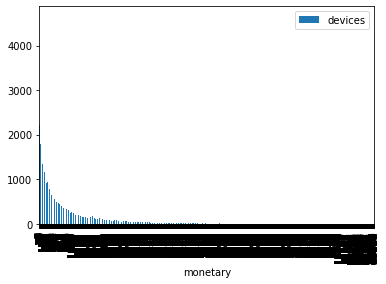

In [13]:
ress.plot(y='devices', x ='monetary', kind='bar')

In [15]:
import jenkspy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%matplotlib inline

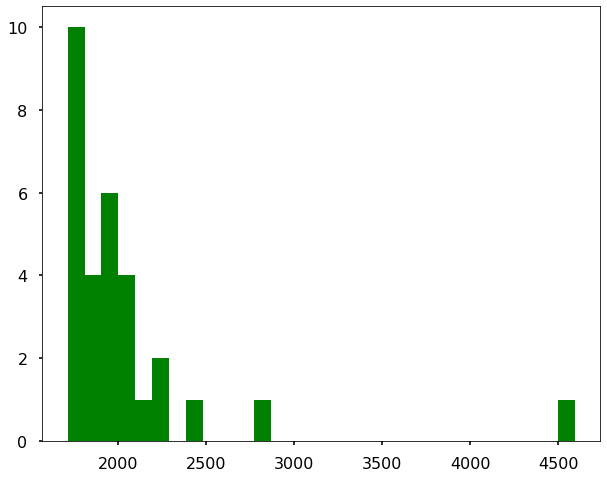

In [19]:
plt.figure(figsize = (10,8))
hist = plt.hist(ress[ress['monetary']<30]['devices'], bins=30, align='left', color='g')